In [1]:
# 查看当前挂载的数据集目录, 该目录下的变更重启环境后会自动还原
# View dataset directory. 
# This directory will be recovered automatically after resetting environment. 
!ls /home/aistudio/data

data19469  data23828


In [2]:
# 查看工作区文件, 该目录下的变更将会持久保存. 请及时清理不必要的文件, 避免加载过慢.
# View personal work directory. 
# All changes under this directory will be kept even after reset. 
# Please clean unnecessary files in time to speed up environment loading. 
!ls /home/aistudio/work

palm


In [3]:
# 同时添加如下代码, 这样每次环境(kernel)启动的时候只要运行下方代码即可: 
# Also add the following code, 
# so that every time the environment (kernel) starts, 
# just run the following code: 
import sys 
sys.path.append('work')

In [4]:
# 导入需要的包
import paddle
import numpy as np
from paddle.nn import Conv2D, MaxPool2D, Linear
import os
import random
import matplotlib.pyplot as plt

## 组网
import paddle.nn.functional as F

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/__init__.py:107: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import MutableMapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/rcsetup.py:20: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable, Mapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/colors.py:53: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sized


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data


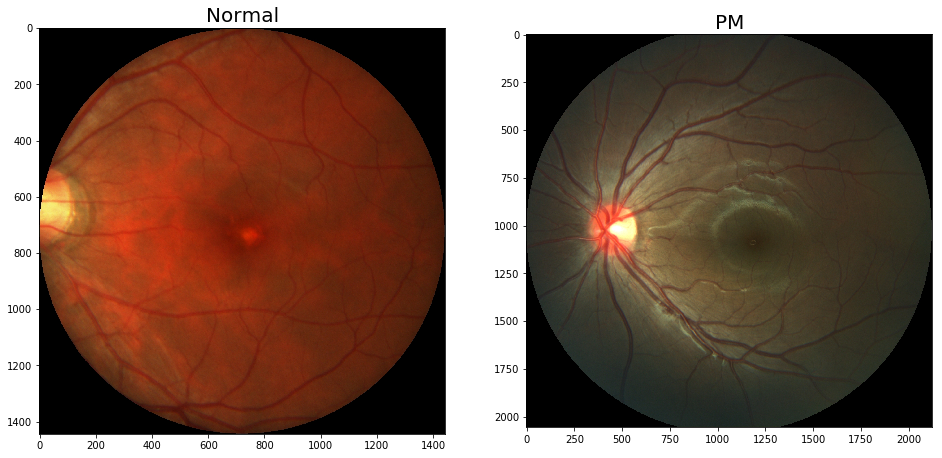

((1444, 1444, 3), (2056, 2124, 3))

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image

DATADIR = '/home/aistudio/work/palm/PALM-Training400/PALM-Training400'
# 文件名以N开头的是正常眼底图片，以P开头的是病变眼底图片
file1 = 'H0026.jpg'
file2 = 'N0161.jpg'

# 读取图片
img1 = Image.open(os.path.join(DATADIR, file1))
img1 = np.array(img1)
img2 = Image.open(os.path.join(DATADIR, file2))
img2 = np.array(img2)

# 画出读取的图片
plt.figure(figsize=(16, 8))
f = plt.subplot(121)
f.set_title('Normal', fontsize=20)
plt.imshow(img1)
f = plt.subplot(122)
f.set_title('PM', fontsize=20)
plt.imshow(img2)
plt.show()
# 查看图片形状
img1.shape, img2.shape

In [7]:
import cv2
import random
import numpy as np
import os

# 对读入的图像数据进行预处理
def transform_img(img):
    # 将图片尺寸缩放道 299×299
    img = cv2.resize(img, (299, 299))
    # 读入的图像数据格式是[H, W, C]
    # 使用转置操作将其变成[C, H, W]
    img = np.transpose(img, (2,0,1))
    img = img.astype('float32')
    # 将数据范围调整到[-1.0, 1.0]之间
    img = img / 255.
    img = img * 2.0 - 1.0
    return img

# 定义训练集数据读取器
def data_loader(datadir, batch_size=10, mode = 'train'):
    # 将datadir目录下的文件列出来，每条文件都要读入
    filenames = os.listdir(datadir)
    def reader():
        if mode == 'train':
            # 训练时随机打乱数据顺序
            random.shuffle(filenames)
        batch_imgs = []
        batch_labels = []
        for name in filenames:
            filepath = os.path.join(datadir, name)
            img = cv2.imread(filepath)
            img = transform_img(img)
            if name[0] == 'H' or name[0] == 'N':
                # H开头的文件名表示高度近似，N开头的文件名表示正常视力
                # 高度近视和正常视力的样本，都不是病理性的，属于负样本，标签为0
                label = 0
            elif name[0] == 'P':
                # P开头的是病理性近视，属于正样本，标签为1
                label = 1
            else:
                raise('Not excepted file name')
            # 每读取一个样本的数据，就将其放入数据列表中
            batch_imgs.append(img)
            batch_labels.append(label)
            if len(batch_imgs) == batch_size:
                # 当数据列表的长度等于batch_size的时候，
                # 把这些数据当作一个mini-batch，并作为数据生成器的一个输出
                imgs_array = np.array(batch_imgs).astype('float32')
                labels_array = np.array(batch_labels).astype('float32').reshape(-1, 1)
                yield imgs_array, labels_array
                batch_imgs = []
                batch_labels = []

        if len(batch_imgs) > 0:
            # 剩余样本数目不足一个batch_size的数据，一起打包成一个mini-batch
            imgs_array = np.array(batch_imgs).astype('float32')
            labels_array = np.array(batch_labels).astype('float32').reshape(-1, 1)
            yield imgs_array, labels_array

    return reader

# 定义验证集数据读取器
def valid_data_loader(datadir, csvfile, batch_size=10, mode='valid'):
    # 训练集读取时通过文件名来确定样本标签，验证集则通过csvfile来读取每个图片对应的标签
    # 请查看解压后的验证集标签数据，观察csvfile文件里面所包含的内容
    # csvfile文件所包含的内容格式如下，每一行代表一个样本，
    # 其中第一列是图片id，第二列是文件名，第三列是图片标签，
    # 第四列和第五列是Fovea的坐标，与分类任务无关
    # ID,imgName,Label,Fovea_X,Fovea_Y
    # 1,V0001.jpg,0,1157.74,1019.87
    # 2,V0002.jpg,1,1285.82,1080.47
    # 打开包含验证集标签的csvfile，并读入其中的内容
    filelists = open(csvfile).readlines()
    def reader():
        batch_imgs = []
        batch_labels = []
        for line in filelists[1:401]:
            line = line.strip().split(',')
            name = line[1]
            label = int(line[2])
            # 根据图片文件名加载图片，并对图像数据作预处理
            filepath = os.path.join(datadir, name)
            img = cv2.imread(filepath)
            img = transform_img(img)
            # 每读取一个样本的数据，就将其放入数据列表中
            batch_imgs.append(img)
            batch_labels.append(label)
            if len(batch_imgs) == batch_size:
                # 当数据列表的长度等于batch_size的时候，
                # 把这些数据当作一个mini-batch，并作为数据生成器的一个输出
                imgs_array = np.array(batch_imgs).astype('float32')
                labels_array = np.array(batch_labels).astype('float32').reshape(-1, 1)
                yield imgs_array, labels_array
                batch_imgs = []
                batch_labels = []

        if len(batch_imgs) > 0:
            # 剩余样本数目不足一个batch_size的数据，一起打包成一个mini-batch
            imgs_array = np.array(batch_imgs).astype('float32')
            labels_array = np.array(batch_labels).astype('float32').reshape(-1, 1)
            yield imgs_array, labels_array

    return reader

In [8]:
# 查看数据形状
DATADIR = '/home/aistudio/work/palm/PALM-Training400/PALM-Training400'
DATADIR2='work/palm/PALM-Validation400'
CSVFILE='work/palm/PALM-Validation-GT/PM_Label_and_Fovea_Location.csv'
train_loader = data_loader(DATADIR, 
                           batch_size=10, mode='train')
data_reader = train_loader()
data = next(data_reader)
print(data[0].shape)
print(data[1].shape)

valid_loader = valid_data_loader(DATADIR2, CSVFILE)
valid_reader = valid_loader()
valid = next(valid_reader)
print(valid[0].shape)
print(valid[1].shape)

(10, 3, 299, 299)
(10, 1)
(10, 3, 299, 299)
(10, 1)


In [17]:
# 导入库
import numpy as np
import paddle
import paddle.nn as nn
from paddle.nn import Conv2D, MaxPool2D, AdaptiveAvgPool2D, Linear
## 组网
import paddle.nn.functional as F

# 定义InceptionV3块中包含的各个子模块



#第一个子模块：一共有四个分支，从Branch_0到Branch_3，第一个分支由64个1×1的卷积组成；第二个分支由48个1×1的卷积，连接64个5×5的卷积；
#            第三个分支由64个1×1的卷积，连接2个有96输出通道的3×3的卷积；第四个分支为3×3的平均池化，连接32输出通道的1×1的卷积。

class InceptionA(nn.Layer):
    def __init__(self, in_channels, pool_features):
        super(InceptionA, self).__init__()
        self.branch1x1 = BasicConv2d(in_channels, 64, kernel_size=1)

        self.branch5x5_1 = BasicConv2d(in_channels, 48, kernel_size=1)
        self.branch5x5_2 = BasicConv2d(48, 64, kernel_size=5, padding=2)

        self.branch3x3dbl_1 = BasicConv2d(in_channels, 64, kernel_size=1)
        self.branch3x3dbl_2 = BasicConv2d(64, 96, kernel_size=3, padding=1)
        self.branch3x3dbl_3 = BasicConv2d(96, 96, kernel_size=3, padding=1)

        self.branch_pool = BasicConv2d(in_channels, pool_features, kernel_size=1)

    def forward(self, x):
        branch1x1 = self.branch1x1(x)

        branch5x5 = self.branch5x5_1(x)
        branch5x5 = self.branch5x5_2(branch5x5)

        branch3x3dbl = self.branch3x3dbl_1(x)
        branch3x3dbl = self.branch3x3dbl_2(branch3x3dbl)
        branch3x3dbl = self.branch3x3dbl_3(branch3x3dbl)

        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch5x5, branch3x3dbl, branch_pool]
        return paddle.concat(outputs, axis=1)



#第二个子模块：它一共包含了3个分支。第一个分支是一个384输出通道的3×3的卷积，步长为2，padding为VALID，所以输出的图片尺寸会被缩小，由原来的35×35缩小为17×17;
#             第二个分支由三层组成，第一层是一个64通道的1×1的卷积和两个96通道的3×3的卷积。最后一层最大池化层的步长为2，padding为VALID，所以图片尺寸也会被压缩

class InceptionB(nn.Layer):
    def __init__(self, in_channels):
        super(InceptionB, self).__init__()
        self.branch3x3 = BasicConv2d(in_channels, 384, kernel_size=3, stride=2)

        self.branch3x3dbl_1 = BasicConv2d(in_channels, 64, kernel_size=1)
        self.branch3x3dbl_2 = BasicConv2d(64, 96, kernel_size=3, padding=1)
        self.branch3x3dbl_3 = BasicConv2d(96, 96, kernel_size=3, stride=2)

    def forward(self, x):
        branch3x3 = self.branch3x3(x)

        branch3x3dbl = self.branch3x3dbl_1(x)
        branch3x3dbl = self.branch3x3dbl_2(branch3x3dbl)
        branch3x3dbl = self.branch3x3dbl_3(branch3x3dbl)

        branch_pool = F.max_pool2d(x, kernel_size=3, stride=2)

        outputs = [branch3x3, branch3x3dbl, branch_pool]
        return paddle.concat(outputs, axis=1)



#第三个子模块：由4个分支所组成，第一个分支是一个简单的192输出通道的1×1的卷积；
#             第二个分支由三层卷积组成，第一层是128输出通道的1×1的卷积，第二层是一个128通道的1×7的卷积，第三层是一个192通道的7×1的卷积。
#             通过串联1×7的卷积和7×1的卷积来替代7×7的卷积，不仅可以减少参数减轻过拟合，同时还增加了一层非线性特征变换；
#             第三个分支由五个卷积层组成，分别是128通道的1×1的卷积，128通道的7×1的卷积，128通道的1×7的卷积，128通道的7×1卷积和192通道的1×7卷积；
#             第四个分支是一个3×3的平均池化层，再连接192通道的1×1的卷积。

class InceptionC(nn.Layer):
    def __init__(self, in_channels, channels_7x7):
        super(InceptionC, self).__init__()
        self.branch1x1 = BasicConv2d(in_channels, 192, kernel_size=1)

        c7 = channels_7x7
        self.branch7x7_1 = BasicConv2d(in_channels, c7, kernel_size=1)
        self.branch7x7_2 = BasicConv2d(c7, c7, kernel_size=(1, 7), padding=(0, 3))
        self.branch7x7_3 = BasicConv2d(c7, 192, kernel_size=(7, 1), padding=(3, 0))

        self.branch7x7dbl_1 = BasicConv2d(in_channels, c7, kernel_size=1)
        self.branch7x7dbl_2 = BasicConv2d(c7, c7, kernel_size=(7, 1), padding=(3, 0))
        self.branch7x7dbl_3 = BasicConv2d(c7, c7, kernel_size=(1, 7), padding=(0, 3))
        self.branch7x7dbl_4 = BasicConv2d(c7, c7, kernel_size=(7, 1), padding=(3, 0))
        self.branch7x7dbl_5 = BasicConv2d(c7, 192, kernel_size=(1, 7), padding=(0, 3))

        self.branch_pool = BasicConv2d(in_channels, 192, kernel_size=1)

    def forward(self, x):
        branch1x1 = self.branch1x1(x)

        branch7x7 = self.branch7x7_1(x)
        branch7x7 = self.branch7x7_2(branch7x7)
        branch7x7 = self.branch7x7_3(branch7x7)

        branch7x7dbl = self.branch7x7dbl_1(x)
        branch7x7dbl = self.branch7x7dbl_2(branch7x7dbl)
        branch7x7dbl = self.branch7x7dbl_3(branch7x7dbl)
        branch7x7dbl = self.branch7x7dbl_4(branch7x7dbl)
        branch7x7dbl = self.branch7x7dbl_5(branch7x7dbl)

        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch7x7, branch7x7dbl, branch_pool]
        return paddle.concat(outputs, axis=1)



#第四个子模块：包含三个分支，第一个分支由两层卷积组成，第一层为192个1×1卷积；第二层是一个320输出通道的3×3的卷积，步长为2，padding为VALID，所以输出的图片尺寸会被缩小，由原来的17×17缩小为8×8
#             第二个分支由四层卷积组成，第一层是192输出通道的1×1的卷积，第二层是一个192通道的1×7的卷积，第三层为192通道的7×1的卷积，第四层是一个192通道的3×3，步长为2的卷积。
#             第三个分支为3×3，步长为2的最大池化层

class InceptionD(nn.Layer):
    def __init__(self, in_channels):
        super(InceptionD, self).__init__()
        self.branch3x3_1 = BasicConv2d(in_channels, 192, kernel_size=1)
        self.branch3x3_2 = BasicConv2d(192, 320, kernel_size=3, stride=2)

        self.branch7x7x3_1 = BasicConv2d(in_channels, 192, kernel_size=1)
        self.branch7x7x3_2 = BasicConv2d(192, 192, kernel_size=(1, 7), padding=(0, 3))
        self.branch7x7x3_3 = BasicConv2d(192, 192, kernel_size=(7, 1), padding=(3, 0))
        self.branch7x7x3_4 = BasicConv2d(192, 192, kernel_size=3, stride=2)

    def forward(self, x):
        branch3x3 = self.branch3x3_1(x)
        branch3x3 = self.branch3x3_2(branch3x3)

        branch7x7x3 = self.branch7x7x3_1(x)
        branch7x7x3 = self.branch7x7x3_2(branch7x7x3)
        branch7x7x3 = self.branch7x7x3_3(branch7x7x3)
        branch7x7x3 = self.branch7x7x3_4(branch7x7x3)

        branch_pool = F.max_pool2d(x, kernel_size=3, stride=2)
        outputs = [branch3x3, branch7x7x3, branch_pool]
        return paddle.concat(outputs, axis=1)



#第五个子模块：由四个分支组成，第一个分支为320输出通道的1×1卷积
#             第二个分支由两个卷积层组成，第一层为384通道的1×1卷积，第二层为384通道的1×3卷积和3×1卷积的叠加
#             第三个分支由三个卷积层组成，第一层为448通道的1×1卷积，第二层为384通道的3×3卷积，第三层为384通道的1×3卷积和3×1卷积的叠加
#             第四个分支为3×3最大池化层后接192通道的1×1卷积

class InceptionE(nn.Layer):
    def __init__(self, in_channels):
        super(InceptionE, self).__init__()
        self.branch1x1 = BasicConv2d(in_channels, 320, kernel_size=1)

        self.branch3x3_1 =BasicConv2d(in_channels, 384, kernel_size=1)
        self.branch3x3_2a = BasicConv2d(384, 384, kernel_size=(1, 3), padding=(0, 1))
        self.branch3x3_2b = BasicConv2d(384, 384, kernel_size=(3, 1), padding=(1, 0))

        self.branch3x3dbl_1 = BasicConv2d(in_channels, 448, kernel_size=1)
        self.branch3x3dbl_2 = BasicConv2d(448, 384, kernel_size=3, padding=1)
        self.branch3x3dbl_3a = BasicConv2d(384, 384, kernel_size=(1, 3), padding=(0, 1))
        self.branch3x3dbl_3b = BasicConv2d(384, 384, kernel_size=(3, 1), padding=(1, 0))

        self.branch_pool = BasicConv2d(in_channels, 192, kernel_size=1)

    def forward(self, x):
        branch1x1 = self.branch1x1(x)

        branch3x3 = self.branch3x3_1(x)
        branch3x3 = [
            self.branch3x3_2a(branch3x3),
            self.branch3x3_2b(branch3x3),
        ]
        branch3x3 = paddle.concat(branch3x3, axis=1)

        branch3x3dbl = self.branch3x3dbl_1(x)
        branch3x3dbl = self.branch3x3dbl_2(branch3x3dbl)
        branch3x3dbl = [
            self.branch3x3dbl_3a(branch3x3dbl),
            self.branch3x3dbl_3b(branch3x3dbl),
        ]
        branch3x3dbl = paddle.concat(branch3x3dbl, axis=1)

        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch3x3, branch3x3dbl, branch_pool]
        return paddle.concat(outputs, axis=1)



#定义基本的卷积块：每层卷积之后都进行Batchnormal和relu激活
class BasicConv2d(nn.Layer):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(BasicConv2d, self).__init__()
        self.conv2d=nn.Conv2D(in_channels,out_channels,bias_attr=False,**kwargs)
        self.bn=nn.BatchNorm2D(out_channels,epsilon=0.001)

    def forward(self, x):
        x = self.conv2d(x)
        x=self.bn(x)
        return F.relu(x)




In [10]:
#定义InceptionV3网络
class Inception3(nn.Layer):
    def __init__(self, num_classes=2, aux_logits=True, transform_input=False):
        super(Inception3, self).__init__()
        self.aux_logits = aux_logits
        self.transform_input = transform_input
        self.Conv2d_1a_3x3 = Conv2D(3, 32, kernel_size=3, stride=2)
        self.Conv2d_2a_3x3 = Conv2D(32, 32, kernel_size=3)
        self.Conv2d_2b_3x3 = Conv2D(32, 64, kernel_size=3, padding=1)
        self.Conv2d_3b_1x1 = Conv2D(64, 80, kernel_size=1)
        self.Conv2d_4a_3x3 = Conv2D(80, 192, kernel_size=3)
        self.Mixed_5b = InceptionA(192, pool_features=32)
        self.Mixed_5c = InceptionA(256, pool_features=64)
        self.Mixed_5d = InceptionA(288, pool_features=64)
        self.Mixed_6a = InceptionB(288)
        self.Mixed_6b = InceptionC(768, channels_7x7=128)
        self.Mixed_6c = InceptionC(768, channels_7x7=160)
        self.Mixed_6d = InceptionC(768, channels_7x7=160)
        self.Mixed_6e = InceptionC(768, channels_7x7=192)
        self.Mixed_7a = InceptionD(768)
        self.Mixed_7b = InceptionE(1280)
        self.Mixed_7c = InceptionE(2048)
        
        self.fc = nn.Linear(2048,1)


    def forward(self, x):
        #输入图片先进行三层卷积
        # N*3*299*299
        x = self.Conv2d_1a_3x3(x)
        # N*32*149*149
        x = self.Conv2d_2a_3x3(x)
        # N*32*147*147
        x = self.Conv2d_2b_3x3(x)

        #进行最大池化
        # N*64*147*147
        x = F.max_pool2d(x, kernel_size=3, stride=2)

        #两层卷积后再接一个最大池化
        # N*64*73*73
        x = self.Conv2d_3b_1x1(x)
        # N*80*73*73
        x = self.Conv2d_4a_3x3(x)
        # N*192*71*71
        x = F.max_pool2d(x, kernel_size=3, stride=2)

        #第一个Inception模块，包含三个子模块
        # N*192*35*35
        x = self.Mixed_5b(x)
        # N*256*35*35
        x = self.Mixed_5c(x)
        # N*288*35*35
        x = self.Mixed_5d(x)

        #第二个Inception模块，包含五个子模块
        # N*288*35*35
        x = self.Mixed_6a(x)
        # N*768*17*17
        x = self.Mixed_6b(x)
        # N*768*17*17
        x = self.Mixed_6c(x)
        # N*768*17*17
        x = self.Mixed_6d(x)
        # N*768*17*17
        x = self.Mixed_6e(x)

        #第三个Inception模块，包含三个子模块
        # N*768*17*17
        x = self.Mixed_7a(x)
        # N*1280*8*8
        x = self.Mixed_7b(x)
        # N*2048*8*8
        x = self.Mixed_7c(x)

        # N*2048*8*8
        x = F.avg_pool2d(x, kernel_size=8)

        #dropout防止过拟合
        # N*2048*1*1
        x = F.dropout(x, training=self.training)

        # N*2048*1*1
        x = paddle.fluid.layers.reshape(x,(-1,2048))
        # N*2048
        x = self.fc(x)
        return x



In [22]:
import os
import random
import paddle
import numpy as np

DATADIR = '/home/aistudio/work/palm/PALM-Training400/PALM-Training400'
DATADIR2 = '/home/aistudio/work/palm/PALM-Validation400'
CSVFILE = '/home/aistudio/work/palm/PALM-Validation-GT/PM_Label_and_Fovea_Location.csv'

# 定义训练过程
def train_pm(model, optimizer):
    # 开启0号GPU训练
    use_gpu = True
    paddle.set_device('gpu:0') if use_gpu else paddle.set_device('cpu')


    print('start training ... ')
    model.train()
    epoch_num = 10
    # 定义数据读取器，训练数据读取器和验证数据读取器
    train_loader = data_loader(DATADIR, batch_size=10, mode='train')
    valid_loader = valid_data_loader(DATADIR2, CSVFILE)
    for epoch in range(epoch_num):
        for batch_id, data in enumerate(train_loader()):
            x_data, y_data = data
            img = paddle.to_tensor(x_data)
            label = paddle.to_tensor(y_data)
            # 运行模型前向计算，得到预测值
            logits = model(img)
            #print(logits)
            loss = F.binary_cross_entropy_with_logits(logits, label)
            avg_loss = paddle.mean(loss)

            if batch_id % 10 == 0:
                print("epoch: {}, batch_id: {}, loss is: {}".format(epoch, batch_id, avg_loss.numpy()))
            # 反向传播，更新权重，清除梯度
            avg_loss.backward()
            optimizer.step()
            optimizer.clear_grad()

        model.eval()
        accuracies = []
        losses = []
        for batch_id, data in enumerate(valid_loader()):
            x_data, y_data = data
            img = paddle.to_tensor(x_data)
            label = paddle.to_tensor(y_data)
            # 运行模型前向计算，得到预测值
            logits = model(img)
            # 二分类，sigmoid计算后的结果以0.5为阈值分两个类别
            # 计算sigmoid后的预测概率，进行loss计算
            pred = F.sigmoid(logits)
            loss = F.binary_cross_entropy_with_logits(logits, label)
            # 计算预测概率小于0.5的类别
            pred2 = pred * (-1.0) + 1.0
            # 得到两个类别的预测概率，并沿第一个维度级联
            pred = paddle.concat([pred2, pred], axis=1)
            acc = paddle.metric.accuracy(pred, paddle.cast(label, dtype='int64'))

            accuracies.append(acc.numpy())
            losses.append(loss.numpy())
        print("[validation] accuracy/loss: {}/{}".format(np.mean(accuracies), np.mean(losses)))
        model.train()

        paddle.save(model.state_dict(), 'palm.pdparams')
        paddle.save(optimizer.state_dict(), 'palm.pdopt')


# 定义评估过程
def evaluation(model, params_file_path):

    # 开启0号GPU预估
    use_gpu = True
    paddle.set_device('gpu:0') if use_gpu else paddle.set_device('cpu')

    print('start evaluation .......')

    #加载模型参数
    model_state_dict = paddle.load(params_file_path)
    model.load_dict(model_state_dict)

    model.eval()
    eval_loader = data_loader(DATADIR, 
                        batch_size=10, mode='eval')

    acc_set = []
    avg_loss_set = []
    for batch_id, data in enumerate(eval_loader()):
        x_data, y_data = data
        img = paddle.to_tensor(x_data)
        label = paddle.to_tensor(y_data)
        y_data = y_data.astype(np.int64)
        label_64 = paddle.to_tensor(y_data)
        # 计算预测和精度
        prediction= model(img)
        # 计算损失函数值
        loss = F.binary_cross_entropy_with_logits(prediction, label)
        pred = F.sigmoid(prediction)
        pred2 = pred * (-1.0) + 1.0
        avg_loss = paddle.mean(loss)
        pred = paddle.concat([pred2, pred], axis=1)
        acc = paddle.metric.accuracy(pred, paddle.cast(label, dtype='int64'))
        acc_set.append(float(acc.numpy()))
        avg_loss_set.append(float(avg_loss.numpy()))
    # 求平均精度
    acc_val_mean = np.array(acc_set).mean()
    avg_loss_val_mean = np.array(avg_loss_set).mean()

    print('loss={}, acc={}'.format(avg_loss_val_mean, acc_val_mean))

In [16]:
# 创建模型
model = Inception3()
print(len(model.parameters()))
opt = paddle.optimizer.Momentum(learning_rate=0.001, momentum=0.9, parameters=model.parameters(), weight_decay=0.001)
# 启动训练过程
train_pm(model, opt)

457
start training ... 
epoch: 0, batch_id: 0, loss is: [0.94968736]
epoch: 0, batch_id: 10, loss is: [0.39073807]
epoch: 0, batch_id: 20, loss is: [0.6318881]
epoch: 0, batch_id: 30, loss is: [0.4312806]
[validation] accuracy/loss: 0.5275000333786011/1.1046172380447388
epoch: 1, batch_id: 0, loss is: [0.41575748]
epoch: 1, batch_id: 10, loss is: [0.30102402]
epoch: 1, batch_id: 20, loss is: [0.31958437]
epoch: 1, batch_id: 30, loss is: [0.27582723]
[validation] accuracy/loss: 0.9300000071525574/0.23307979106903076
epoch: 2, batch_id: 0, loss is: [0.16234106]
epoch: 2, batch_id: 10, loss is: [0.08510575]
epoch: 2, batch_id: 20, loss is: [0.2072247]
epoch: 2, batch_id: 30, loss is: [0.57505065]
[validation] accuracy/loss: 0.8575000762939453/0.328180730342865
epoch: 3, batch_id: 0, loss is: [0.3322381]
epoch: 3, batch_id: 10, loss is: [0.13484651]
epoch: 3, batch_id: 20, loss is: [0.05858833]
epoch: 3, batch_id: 30, loss is: [0.08297157]
[validation] accuracy/loss: 0.9424999952316284/0.2

In [23]:
evaluation(model,'palm.pdparams')

start evaluation .......
loss=0.1041734388563782, acc=0.9649999931454658


请点击[此处](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576)查看本环境基本用法.  <br>
Please click [here ](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576) for more detailed instructions. 